In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np
import re
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import mannwhitneyu
from scipy import stats
import matplotlib.ticker as ticker
import os
from reload_recursive import reload_recursive
import patsy
from pyprocessmacro import Process
from statsmodels.stats.mediation import Mediation
from statsmodels.miscmodels.ordinal_model import OrderedModel
from pingouin import mediation_analysis

from mri_data import file_manager as fm
import helpers

In [2]:
reload_recursive(helpers)

## Setup

In [3]:
drive_root = fm.get_drive_root()
msmri_home = Path("/home/srs-9/Projects/ms_mri")
msmri_datadir = msmri_home / "data"
curr_dir = Path(os.getcwd())
data_dir = curr_dir / "data0"
showfigs = False
# pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.precision = 3
colors = helpers.get_colors()

In [4]:
# df = pd.read_csv(data_dir / "t1_2_data_full.csv", index_col="subid")
df = pd.read_csv(data_dir / "t1_aschoplex_data_full.csv", index_col="subid")
df_full = df.copy()
df_tmp = pd.read_csv(data_dir / "t1_2_data_full.csv", index_col="subid")
df['pineal_volume'] = df_tmp['pineal_volume']
df['pituitary_volume'] = df_tmp['pituitary_volume']

df = helpers.get_mri_edss_delta(df)

keep_cols = [
    "subject",
    "age",
    "sex",
    "ms_type",
    "dzdur",
    "extracted_EDSS",
    "MSSS",
    "gMSSS",
    "ARMSS",
    "edss_mri_delta",
    "edss_date_closest",
    "mri_date_closest",
    "DMT_score",
    "DMT_hx_all",
    "TER",
    "DMF",
    "NAT",
    "INF",
    "flair_contrast",
    "thalamus",
    "brain",
    "white",
    "grey",
    "cortical_thickness",
    "lesion_count",
    "lesion_vol_cubic",
    "PRL",
    "tiv",
    "choroid_volume",
    "pineal_volume", 
    "pituitary_volume"
]
df = df.loc[:, keep_cols]

df = helpers.set_dz_type5(df)
df = helpers.set_dz_type3(df)
df = helpers.set_dz_type2(df)
df = helpers.fix_edss(df)
df = helpers.clean_df(df)
df = helpers.set_has_prl(df)
df = helpers.norm_volumes(df)

df.rename(columns={"lesion_vol_cubic": "t2lv"}, inplace=True)
df = df.rename(columns={"extracted_EDSS": "EDSS"})

df = helpers.do_sqrt_transform(df, ["EDSS", "MSSS", "ARMSS", "gMSSS"])
df = helpers.do_log_transform(df, ["t2lv"])

vars_to_center = ["EDSS_sqrt", "t2lv_logtrans", "t2lv", "dzdur", "choroid_volume", "PRL"]
df = helpers.do_center(df, vars_to_center)

vars_to_scale = [
    "age",
    "dzdur",
    "lesion_count",
    "t2lv",
    "t2lv_logtrans",
    "PRL",
    "tiv",
    "choroid_volume",
    "thalamus"
]
df = helpers.do_scale(df, vars_to_scale)

numeric_vars = [
    "age",
    "dzdur",
    "Female",
    "EDSS", "EDSS_sqrt",
    "MSSS", "MSSS_sqrt",
    "gMSSS", "gMSSS_sqrt",
    "ARMSS", "ARMSS_sqrt",
    "edss_mri_delta",
    "DMT_score",
    "DMT_hx_all",
    "TER",
    "DMF",
    "NAT",
    "INF",
    "thalamus",
    "brain",
    "white",
    "grey",
    "cortical_thickness",
    "lesion_count",
    "t2lv", "t2lv_logtrans",
    "PRL",
    "tiv",
    "choroid_volume",
    "norm_choroid_volume",
    "pineal_volume",
    "pituitary_volume"
]

for var in numeric_vars:
    df[var] = df[var].astype("float")

df_ms = df.loc[df['dz_type2'] == "MS"]
df_scale = df.copy() #temporary till I rename df_scale everywehre
df_scale_ms = df_scale.loc[df['dz_type2'] == "MS"]

df_z = df[numeric_vars].astype("float")
df_z[df.columns[~df.columns.isin(numeric_vars)]] = df[df.columns[~df.columns.isin(numeric_vars)]]
df_z = df_z[df.columns]
df_z[numeric_vars] = df_z[numeric_vars].apply(stats.zscore, nan_policy="omit")

# delete these vars once I fix all future variable references
data = df[numeric_vars].astype("float")
data_z = data[numeric_vars].apply(stats.zscore, nan_policy="omit")

data_ms = df.loc[df["dz_type5"].isin(["RMS", "PMS"]), :]
data_ms = data_ms[numeric_vars].astype("float")
data_ms_z = data_ms[numeric_vars].apply(stats.zscore, nan_policy="omit")

## Analysis

### Pineal Volume

In [5]:
model_data = df_z.copy()
model_data = model_data[model_data['dz_type2'].isin(["MS", "!MS"])]
model_data = model_data.drop([1548], axis=0)
res = sm.OLS.from_formula(
    "pineal_volume ~ age + tiv + Female + choroid_volume", data=model_data
).fit()

summary = pd.DataFrame({'coef': res.params, 'p': res.pvalues})
print("R2:     {:0.3f}".format(res.rsquared))
print("R2_adj: {:0.3f}".format(res.rsquared_adj))
print(summary)

R2:     0.034
R2_adj: 0.025
                 coef      p
Intercept      -0.021  0.590
age            -0.112  0.007
tiv             0.082  0.078
Female          0.030  0.533
choroid_volume -0.040  0.348


In [6]:
model_data = df_z.copy()
model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
res = sm.OLS.from_formula("pineal_volume ~ dz_type5 + Female + age + tiv", data=model_data).fit()

summary = pd.DataFrame({'coef': res.params, 'p': res.pvalues})
print("R2:     {:0.3f}".format(res.rsquared))
print("R2_adj: {:0.3f}".format(res.rsquared_adj))
print(summary)

R2:     0.047
R2_adj: 0.037
                  coef      p
Intercept       -0.248  0.011
dz_type5[T.RMS]  0.230  0.040
Female          -0.018  0.715
age             -0.105  0.015
tiv              0.054  0.267


See how pineal volume changes with various imaging findings

In [8]:
model_data = df_z
# model_data = df_z[df_z['dz_type5'].isin(["RMS", "PMS"])]
# model_data = df_z[df_z['dz_type5'] == "OIND"]

outcomes = ["t2lv", "PRL", "thalamus", "brain", "grey", "white", "cortical_thickness"]
covariates = "age + Female + tiv"

pvals = {}
coefs = {}

for outcome in outcomes:
    formula = f"{outcome} ~ pituitary_volume + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[outcome] = res.pvalues['pituitary_volume']
    coefs[outcome] = res.params['pituitary_volume']

regression_results = pd.DataFrame({"coef": coefs, "pvals": pvals})
regression_results['p_fdr'] = stats.false_discovery_control(regression_results['pvals'], method='bh')
print(regression_results)

                     coef  pvals  p_fdr
t2lv               -0.022  0.591  0.933
PRL                -0.004  0.933  0.933
thalamus            0.007  0.850  0.933
brain              -0.004  0.922  0.933
grey                0.007  0.850  0.933
white              -0.019  0.670  0.933
cortical_thickness  0.017  0.664  0.933


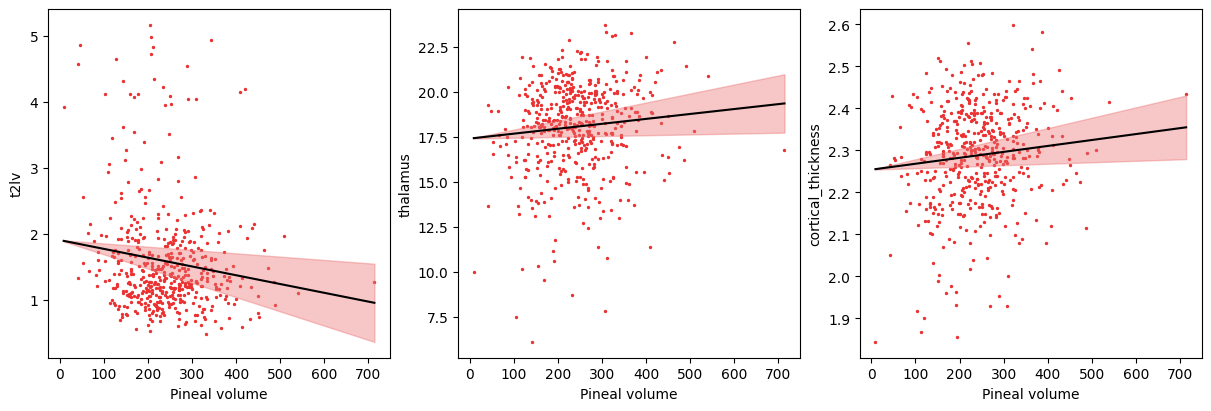

In [24]:
outcomes = ["t2lv", "thalamus", "cortical_thickness"]

fig, axs = plt.subplot_mosaic([outcomes], 
                               figsize=(12, 4),
                               layout='constrained',
                               )

plot_data = data.copy()
plot_data = plot_data[data_z['pineal_volume'] < 5]

dark_color = colors['dark red1']
light_color = colors['light red1']
keep_xticks = outcomes
for outcome in outcomes:
    formula = f"{outcome} ~ pineal_volume + {covariates}"
    res = sm.OLS.from_formula(formula, data=plot_data).fit()
    x, y_pred, y_lims = helpers.get_regression_y(plot_data, res, "pineal_volume", outcome)
    axs[outcome].scatter(plot_data['pineal_volume'], plot_data[outcome], s=2, color=dark_color)
    axs[outcome].plot(x, y_pred, color='black')
    axs[outcome].fill_between(x, y_lims[0], y_lims[1], alpha=0.4, color=light_color)
    axs[outcome].set_ylabel(outcome)
    if outcome not in keep_xticks:
        axs[outcome].set_xlabel("")
        axs[outcome].set_xticklabels([])
    else:
        axs[outcome].set_xlabel("Pineal volume")

In [26]:
moderation_model = sm.OLS.from_formula("thalamus ~ t2lv*pineal_volume + tiv + age + Female", data=data_z)
res = moderation_model.fit()
summary = pd.DataFrame({'coef': res.params, 'p': res.pvalues.round(3)})
print("R2:     {:0.3}".format(res.rsquared))
print("R2_adj: {:0.3}".format(res.rsquared_adj))
print(summary)

R2:     0.396
R2_adj: 0.389
                     coef      p
Intercept          -0.006  0.864
t2lv               -0.389  0.000
pineal_volume       0.040  0.253
t2lv:pineal_volume  0.023  0.540
tiv                -0.023  0.586
age                -0.338  0.000
Female              0.196  0.000


Other correlations

In [27]:
model_data = df_z.copy()
# model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
res = sm.OLS.from_formula("pineal_volume ~ thalamus + Female + age + tiv", data=model_data).fit()

summary = pd.DataFrame({'coef': res.params, 'p': res.pvalues})
print("R2:     {:0.3f}".format(res.rsquared))
print("R2_adj: {:0.3f}".format(res.rsquared_adj))
print(summary)

R2:     0.017
R2_adj: 0.009
                coef      p
Intercept -9.230e-04  0.984
thalamus   1.257e-01  0.020
Female     1.504e-02  0.789
age        9.726e-03  0.846
tiv        7.484e-02  0.170


In [28]:
model_data = df[df['dz_type5'].isin(["RMS", "PMS"])]

res = sm.OLS.from_formula("pineal_volume ~ EDSS + Female + age + tiv", data=model_data).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          pineal_volume   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.533
Date:                Wed, 09 Apr 2025   Prob (F-statistic):              0.192
Time:                        16:17:10   Log-Likelihood:                -2316.5
No. Observations:                 397   AIC:                             4643.
Df Residuals:                     392   BIC:                             4663.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    159.4510     67.458      2.364      0.0

In [39]:
model_data = df[df['dz_type5'].isin(["RMS", "PMS"])]

res = sm.OLS.from_formula("pineal_volume ~ MSSS + DMT_hx_all + dz_type5 + lesion_vol_cubic + PRL + Female + age + tiv", data=model_data).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          pineal_volume   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     3.691
Date:                Mon, 10 Mar 2025   Prob (F-statistic):           0.000368
Time:                        14:23:18   Log-Likelihood:                -2126.4
No. Observations:                 376   AIC:                             4271.
Df Residuals:                     367   BIC:                             4306.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          145.1154     60.193  

In [9]:
model_data = df_z.copy()
model_data = model_data.loc[df['dz_type5'].isin(["RMS", "PMS"]), :]

Do all the univariate regressions with age, sex, and TIV as covariates

In [17]:
predictors = ["pineal_volume", "t2lv", "PRL", "thalamus", "grey", "white", "cortical_thickness"]
covariates = "age + Female + tiv"

pvals = {}
coefs = {}

for predictor in predictors:
    formula = f"EDSS ~ {predictor} + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[predictor] = res.pvalues[predictor]
    coefs[predictor] = res.params[predictor]

regression_results = pd.DataFrame({"coef": coefs, "pvals": pvals})
regression_results

,coef,pvals
pineal_volume,-0.008,8.776e-01
t2lv,0.195,2.239e-04
PRL,0.095,2.476e-02
thalamus,-0.293,3.605e-08
grey,-0.111,4.832e-02
white,-0.010,8.438e-01
cortical_thickness,-0.253,3.297e-06


## Compare Resegmented

In [13]:
df2 = pd.read_csv(data_dir / "t1_2_data_full.csv")
df2 = df2.set_index("subid")

df2 = helpers.set_dz_type5(df2)
df2 = helpers.set_dz_type3(df2)
df2 = helpers.set_dz_type2(df2)
df2 = helpers.fix_edss(df2)
df2 = helpers.clean_df(df2)
df2 = helpers.set_has_prl(df2)

df2 = df2.loc[:, keep_cols]
df2 = pd.concat((df2, pd.get_dummies(df2["sex"], dtype="int")), axis=1)
df2["Intercept"] = 1

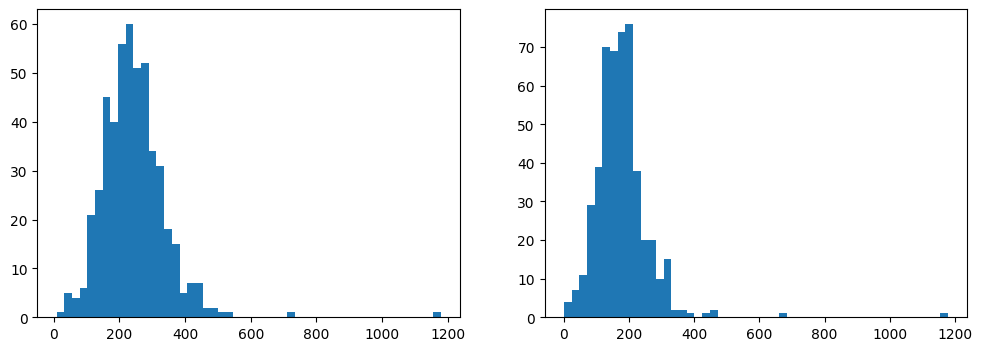

In [20]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].hist(df['pineal_volume'], bins=50)
ax[1].hist(df2['pineal_volume'], bins=50)
plt.show()

<BarContainer object of 2 artists>

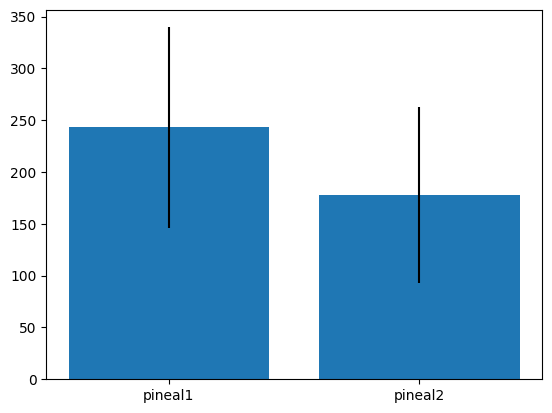

In [22]:
plt.bar(["pineal1", "pineal2"], [df['pineal_volume'].mean(), df2['pineal_volume'].mean()],
        yerr=[df['pineal_volume'].std(), df2['pineal_volume'].std()])